In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

sys.path.append("../utils")


In [2]:
data = pd.read_csv(
    "/capstone/wildfire_prep/data/PUZZLE_PIECES/assembled_puzzle.csv"
).drop(columns=["basemap_id", 'total_rain_three_months_prior'])

In [3]:
# Remove Mosaiks from dataset for testing

mosaiks86 = data[
    [
        "inspection_id",
        "maj_landcover_code_x",
        "maj_landcover_code_y",
        "status",
        "structure_code",
        "current_month_rain",
        "previous_month_rain",
        "two_months_prior_rain",
    ]
]

data = mosaiks86
data.columns


In [4]:
print(data.shape)
print(data.columns)
data.head()

(67580, 4008)
Index(['inspection_id', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_3997', 'X_3998', 'X_3999', 'maj_landcover_code_x',
       'maj_landcover_code_y', 'status', 'structure_code',
       'current_month_rain', 'previous_month_rain', 'two_months_prior_rain'],
      dtype='object', length=4008)


,inspection_id,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,status,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain
0,1,0.054892,0.0,0.015004,0.0,0.238797,0.000466,0.0,0.055266,0.005605,...,1.905394,4.261047,2.500061,304.0,557,0,100,0.28,2.18,0.19
1,2,0.024470,0.0,0.003108,0.0,0.129467,0.000687,0.0,0.034108,0.012225,...,1.661454,3.457836,2.098205,304.0,304,0,101,1.46,0.08,3.19
2,3,0.271383,0.0,0.126712,0.0,0.976787,0.043854,0.0,0.528058,0.124882,...,2.504779,6.486201,3.454411,303.0,303,0,101,1.46,0.08,3.19
3,4,0.097084,0.0,0.037654,0.0,0.549639,0.001046,0.0,0.240636,0.017580,...,2.112541,5.209030,2.868551,39.0,304,0,100,1.46,0.08,3.19
4,5,0.041986,0.0,0.008531,0.0,0.253195,0.001353,0.0,0.036694,0.002605,...,1.853227,4.251881,2.500635,304.0,304,0,101,5.14,1.67,NaN


## Downsample Majority Class Approach


In [5]:
X = data.drop("status", axis=1)
y = data["status"]

upsample_data_ids = X.inspection_id

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train = pd.concat([X_train, y_train], axis=1)

majority = train[train.status == 0]
minority = train[train.status == 1]

n_majority_desired = len(minority) * 3
majority_downsampled = majority.sample(
    n=n_majority_desired, replace=False, random_state=42
)

train_balanced = (
    pd.concat([majority_downsampled, minority])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]

X_test = X_test.drop(columns="inspection_id")

print(f"Shape of compliant:", majority.shape)
print(f"Shape of non-compliant:", minority.shape)

print(f"N_minority desired:", int(len(majority) * 3))

print("Shapes:")
print(" Downsampled X_train:", X_train.shape)
print(" Downsampled y_train:", y_train.shape)
print(" Downsampled X_test: ", X_test.shape)
print(" Downsampled y_test: ", y_test.shape)

print("\nTrain distribution after up-sampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (53730, 4008)
Shape of non-compliant: (334, 4008)
N_minority desired: 161190
Shapes:
 Downsampled X_train: (1336, 4006)
 Downsampled y_train: (1336,)
 Downsampled X_test:  (13516, 4006)
 Downsampled y_test:  (13516,)

Train distribution after up-sampling:
status
0    0.75
1    0.25
Name: proportion, dtype: float64


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain
0,0.980615,0.0,0.498733,0.001490,1.925463,0.219529,0.0,0.982447,0.366697,0.063637,...,1.500538,3.119550,8.773360,4.585543,303.0,582,102,NaN,1.09,0.05
1,0.595608,0.0,0.368074,0.017719,1.460289,0.205838,0.0,0.779316,0.339393,0.055420,...,1.406411,2.920641,7.778569,4.184819,581.0,304,102,0.01,0.51,0.92
2,0.166876,0.0,0.098818,0.000000,0.838690,0.024531,0.0,0.378152,0.045195,0.000267,...,1.303262,2.445058,6.129449,3.333632,303.0,582,102,0.01,0.02,NaN
3,0.251729,0.0,0.217023,0.000000,0.943251,0.136851,0.0,0.667194,0.302191,0.008528,...,1.121837,2.670616,6.626384,3.462433,556.0,556,101,0.03,NaN,NaN
4,0.517334,0.0,0.193630,0.000000,1.533866,0.117757,0.0,0.760257,0.226459,0.012133,...,1.332656,2.960548,7.932229,4.292342,582.0,582,102,0.34,0.45,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,0.214842,0.0,0.084297,0.003410,0.632061,0.075151,0.0,0.250915,0.165691,0.036268,...,1.229582,2.219869,5.227838,3.010955,581.0,304,102,0.19,1.95,0.22
1332,0.659951,0.0,0.438005,0.000000,1.623533,0.192162,0.0,0.806604,0.205872,0.074531,...,1.557677,2.876851,8.065570,4.291951,581.0,303,100,NaN,NaN,0.01
1333,0.346324,0.0,0.281637,0.000000,1.226964,0.136658,0.0,0.847138,0.388027,0.016122,...,1.148208,2.836028,7.401264,3.821792,556.0,581,104,NaN,NaN,NaN
1334,0.870053,0.0,0.559589,0.002623,2.033172,0.348026,0.0,1.069538,0.424388,0.119261,...,1.534886,3.268098,9.213343,4.864600,582.0,303,102,0.06,1.88,0.16


## Upsample Minority Class Approach


In [6]:
X = data.drop("status", axis=1)
y = data["status"]

# Save inspection_ids from the data, in case we need them later
upsample_data_ids = X.inspection_id

# split data, as usual. 20% test data split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Recombine just the train fold
train = pd.concat([X_train, y_train], axis=1)

# Up-sample the minority inside train
majority = train[train.status == 0]
minority = train[train.status == 1]
n_min = int(len(majority) / 3)

minority_upsampled = minority.sample(n=n_min, replace=True, random_state=42)

train_balanced = (
    pd.concat([majority, minority_upsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]
X_test = X_test.drop(columns="inspection_id")

# Check majority/minority sizes
print(f"Shape of compliant:", majority.shape)
print(f"Shape of non-compliant:", minority.shape)

print(f"N_minority desired:", int(len(majority) / 3))

print("Shapes:")
print(" Upsampled X_train:", X_train.shape)
print(" Upsampled y_train:", y_train.shape)
print(" Upsampled X_test: ", X_test.shape)
print(" Upsampled y_test: ", y_test.shape)

print("\nTrain distribution after up-sampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (53730, 4008)
Shape of non-compliant: (334, 4008)
N_minority desired: 17910
Shapes:
 Upsampled X_train: (71640, 4006)
 Upsampled y_train: (71640,)
 Upsampled X_test:  (13516, 4006)
 Upsampled y_test:  (13516,)

Train distribution after up-sampling:
status
0    0.75
1    0.25
Name: proportion, dtype: float64


,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_3996,X_3997,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain
0,0.331932,0.0,0.155317,0.001381,1.019321,0.149126,0.0,0.463005,0.184660,0.054773,...,1.336933,2.510178,6.464772,3.571856,581.0,581,102,0.02,NaN,NaN
1,0.041893,0.0,0.045376,0.000000,0.226781,0.028766,0.0,0.099595,0.104055,0.011859,...,1.153797,1.876783,3.903363,2.304808,583.0,582,102,0.07,0.01,NaN
2,0.487315,0.0,0.205840,0.000000,1.428233,0.080608,0.0,0.678452,0.113209,0.004575,...,1.389064,2.812428,7.569997,4.098632,39.0,581,100,NaN,0.01,0.07
3,0.617308,0.0,0.403863,0.000000,1.630068,0.150945,0.0,0.863991,0.176445,0.001145,...,1.480072,2.952140,8.134626,4.289285,304.0,303,101,0.01,0.01,0.43
4,0.337975,0.0,0.204831,0.000245,1.043153,0.131792,0.0,0.528441,0.154996,0.036168,...,1.299550,2.506843,6.557403,3.541020,581.0,556,107,1.09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71635,0.727093,0.0,0.370492,0.002025,1.537865,0.197491,0.0,0.691560,0.267884,0.081505,...,1.513182,2.763578,7.669852,4.114849,581.0,557,106,0.01,NaN,0.02
71636,0.924879,0.0,0.499406,0.001395,1.933097,0.196872,0.0,0.884723,0.278062,0.062329,...,1.639850,3.075902,8.721411,4.650027,581.0,556,102,6.58,1.44,NaN
71637,0.480514,0.0,0.291867,0.002268,1.447743,0.270847,0.0,0.803332,0.348975,0.106511,...,1.288358,2.952441,7.846379,4.204723,581.0,303,102,0.17,NaN,0.03
71638,0.530461,0.0,0.304156,0.014298,1.248092,0.223953,0.0,0.601414,0.324865,0.148117,...,1.366152,2.641078,7.023295,3.874680,581.0,581,102,0.26,1.37,NaN


In [7]:
# Make code chunk to do both upsampling and downsampling:
# Downsample majority and then upsample minority, all in the same data

## Random Forest Classifier Model


Length of y_pred: 13516
Accuracy: 0.99363717076058


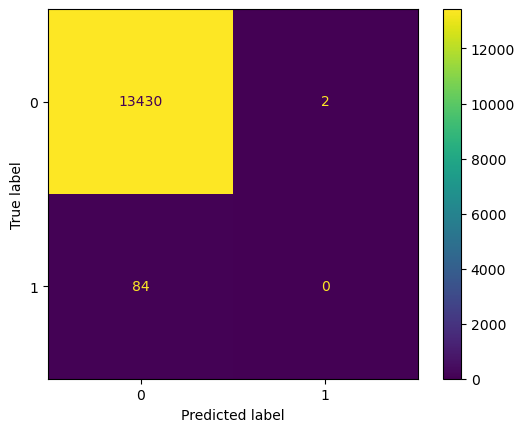

In [8]:
rf = RandomForestClassifier()  # class_weight={0: 1, 1: 3}
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [9]:
param_dist = {
    "max_depth": randint(1, 20),
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features": ["sqrt", "log2", 0.2, 0.5],
    # "class_weight": [None, "balanced", "balanced_subsample"],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1, bootstrap=True)

halving_search = HalvingRandomSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    resource="n_estimators",
    min_resources=20,
    max_resources=200,
    factor=3,
    cv=3,
    scoring="precision",
    n_jobs=1,
    verbose=1,
)

halving_search.fit(X_train, y_train)

best_rf = halving_search.best_estimator_


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/

----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 3 folds for each of 2 candidates, totalling 6 fits


Length of y_pred: 13516
Count of ACTUAL non-compliant properties in test set 84
Count of predicted non-compliant properties: 6
Accuracy: 0.9933412252145605
Best parameters:
 {'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 180}


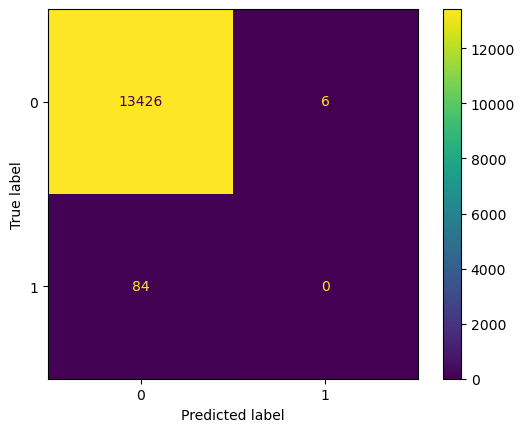

In [56]:
best_params = halving_search.best_params_

best_rf = RandomForestClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    bootstrap=True
)

best_rf.fit(X_train, y_train)


y_scores = best_rf.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = (y_scores >= threshold).astype(int)


accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print(f"Count of ACTUAL non-compliant properties in test set", y_test.sum())
print(f"Count of predicted non-compliant properties:", y_pred.sum())
print("Accuracy:", accuracy)

print(f"Best parameters:\n", best_params)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [11]:
# # RandomizedSeacrchCV cell
# param_dist = {
#     "n_estimators": randint(50, 500),
#     "max_depth": randint(1, 20),
#     "class_weight": [None, "balanced", "balanced_subsample"],
# }

# param_dist.update(
#     {
#         "min_samples_leaf": [1, 5, 10, 20],
#         "max_features": ["sqrt", "log2", 0.2, 0.5],
#     }
# )

# rf = RandomForestClassifier(
#     random_state=42,
#     n_jobs=-1,
#     # ,
#     # max_samples = 0.7,    # added
#     # bootstrap = True      # added
# )
# # random search method
# rand_search = RandomizedSearchCV(
#     rf,
#     param_distributions = param_dist,
#     n_iter = 20,      # increased from 10, originally 20
#     cv = 3,           # increased from 2, originally 3
#     scoring = "precision",
#     #scoring = 'recall',
#     refit = True,
#     n_jobs = 1,
#     verbose = 1,
# )
# rand_search.fit(X_train, y_train)

# best_rf = rand_search.best_estimator_

# y_scores = best_rf.predict_proba(X_test)[:, 1]


In [21]:
# # TESTING PRECISION
# # greatest precision achievable is 0.5, default


# # 6 Quick diagnostic of your score distribution
# print("Probability range:", y_scores.min(), "to", y_scores.max())
# print("Positives at 0.5 cutoff:", (y_scores >= 0.5).sum())

# # 7 Try a few fixed thresholds
# for thresh in np.arange(0.10, 0.95, 0.01):
#     preds = (y_scores >= thresh).astype(int)
#     print(f"\nThreshold {thresh:.001f} → Positives = {preds.sum()}")
#     print(" Precision:", precision_score(y_test, preds))
#     print(" Recall:   ", recall_score(y_test, preds))

# # 8 Precision–Recall curve based threshold search
# precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
# precisions = precisions[:-1]  # align lengths with thresholds

# # What’s the best precision you can actually hit?
# best_possible_precision = precisions.max()
# print("\nBest achievable precision:", best_possible_precision)

# # Now find the first threshold that reaches ≥0.6, if any
# target = 0.6
# valid = np.where(precisions >= target)[0]

# if valid.size:
#     best_idx = valid[0]
#     best_thresh = thresholds[best_idx]
#     print(f"Threshold for ≥{target:.2f} precision:", best_thresh)
#     y_pred_opt = (y_scores >= best_thresh).astype(int)
#     print(" Precision:", precision_score(y_test, y_pred_opt))
#     print(" Recall:   ", recall_score(y_test, y_pred_opt))
# else:
#     print(
#         f"No threshold yields ≥{target:.2f} precision. "
#         f"Falling back to best achievable precision of "
#         f"{best_possible_precision:.3f}."
#     )
#     # you could pick the threshold for that best precision:
#     best_idx = np.argmax(precisions)
#     best_thresh = thresholds[best_idx]
#     print("  Using threshold:", best_thresh)
#     y_pred_opt = (y_scores >= best_thresh).astype(int)
#     print("  Precision:", precision_score(y_test, y_pred_opt))
#     print("  Recall:   ", recall_score(y_test, y_pred_opt))

Probability range: 0.0 to 0.9389610875927116
Positives at 0.5 cutoff: 3

Threshold 0.1 → Positives = 1237
 Precision: 0.00889248181083266
 Recall:    0.13095238095238096

Threshold 0.1 → Positives = 822
 Precision: 0.0072992700729927005
 Recall:    0.07142857142857142

Threshold 0.1 → Positives = 533
 Precision: 0.005628517823639775
 Recall:    0.03571428571428571

Threshold 0.1 → Positives = 362
 Precision: 0.0027624309392265192
 Recall:    0.011904761904761904

Threshold 0.1 → Positives = 260
 Precision: 0.0
 Recall:    0.0

Threshold 0.1 → Positives = 190
 Precision: 0.0
 Recall:    0.0

Threshold 0.2 → Positives = 136
 Precision: 0.0
 Recall:    0.0

Threshold 0.2 → Positives = 94
 Precision: 0.0
 Recall:    0.0

Threshold 0.2 → Positives = 70
 Precision: 0.0
 Recall:    0.0

Threshold 0.2 → Positives = 51
 Precision: 0.0
 Recall:    0.0

Threshold 0.2 → Positives = 40
 Precision: 0.0
 Recall:    0.0

Threshold 0.2 → Positives = 33
 Precision: 0.0
 Recall:    0.0

Threshold 0.2 → P

/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9935631843740752
Precision: 0.0
Recall: 0.0


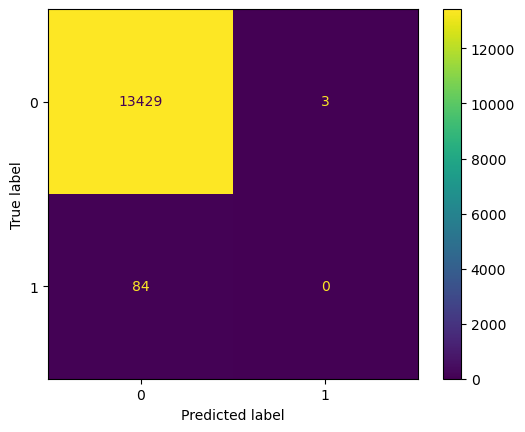

In [13]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)

# # Create the confusion matrix
# cm = confusion_matrix(y_test, y_pred)

# ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [22]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# # For each threshold, compute the false positives (cm[0,1])
# false_positives = []
# for thresh in thresholds:
#     y_pred = (y_scores >= thresh).astype(int)
#     cm = confusion_matrix(y_test, y_pred)
#     false_positives.append(cm[0,1])

# # Find the threshold that minimizes false positives
# best_idx = np.argmin(false_positives)
# best_thresh = thresholds[best_idx]
# print(f"Best threshold (min false positives): {best_thresh:.3f}")


Best threshold (min false positives): 0.939


              precision    recall  f1-score   support

           0       0.99      0.22      0.37     13432
           1       0.01      0.73      0.01        84

    accuracy                           0.23     13516
   macro avg       0.50      0.48      0.19     13516
weighted avg       0.99      0.23      0.36     13516



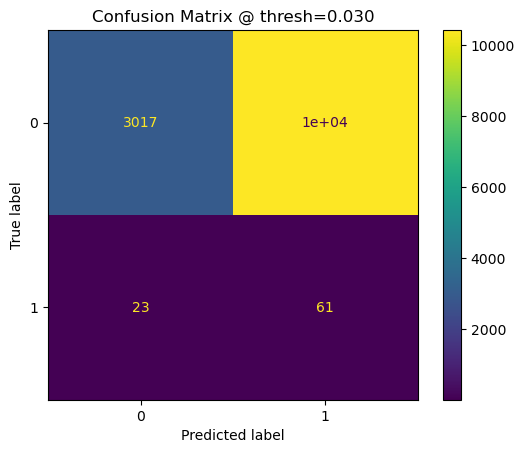

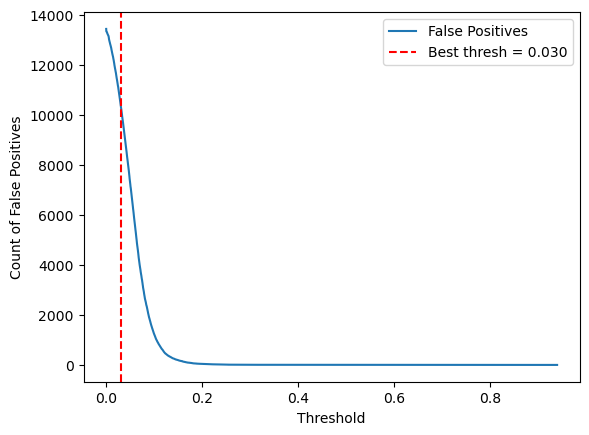

In [33]:
# best_thresh = 0.03
# # Recompute predictions & metrics at that threshold
# y_pred_best = (y_scores >= best_thresh).astype(int)
# print(classification_report(y_test, y_pred_best))

# cm_best = confusion_matrix(y_test, y_pred_best)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_best)
# disp.plot()
# plt.title(f"Confusion Matrix @ thresh={best_thresh:.3f}")
# plt.show()

# # Visualize how false positives vary with threshold
# plt.plot(thresholds, false_positives, label="False Positives")
# plt.axvline(
#     best_thresh, color="red", linestyle="--", label=f"Best thresh = {best_thresh:.3f}"
# )
# plt.xlabel("Threshold")
# plt.ylabel("Count of False Positives")
# plt.legend()
# plt.show()


Feature importances:
 maj_landcover_code_y    0.007237
previous_month_rain     0.001966
structure_code          0.001412
current_month_rain      0.001290
X_2048                  0.001193
dtype: float64


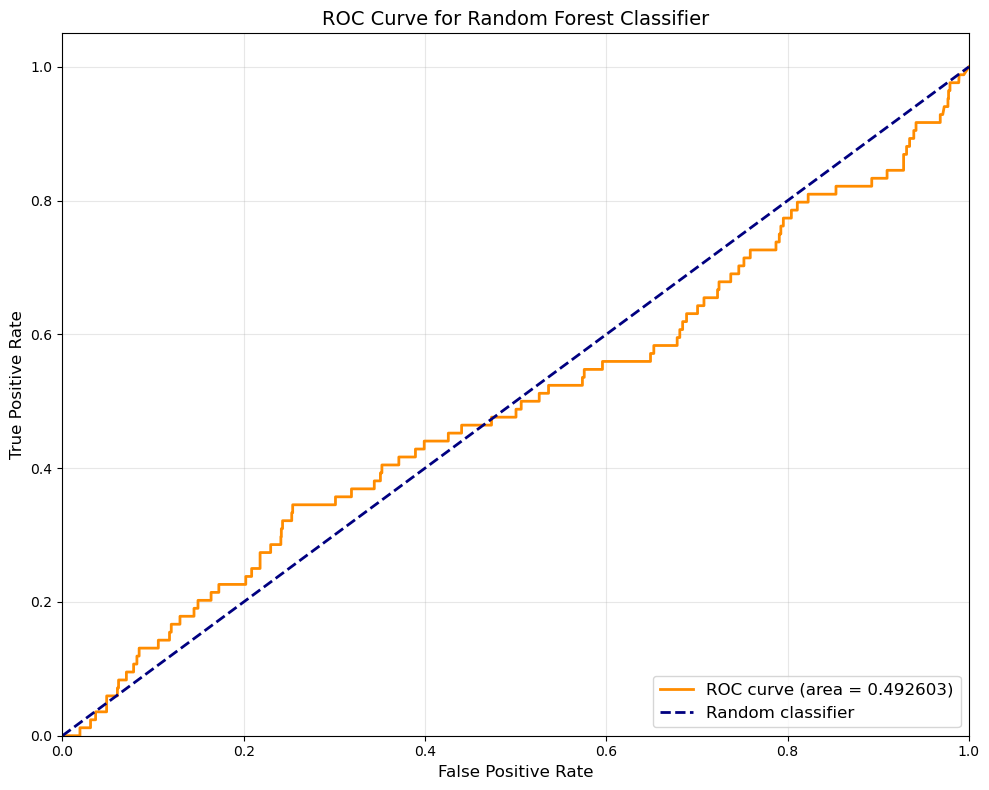

ROC AUC Score: 0.4926


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)
print(f"Feature importances:\n", feature_importances.head())

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.6f})")

# Plot baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random classifier")

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for Random Forest Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f"ROC AUC Score: {roc_auc:.4f}")


In [16]:
actual = y_test.to_numpy()
predicted = y_pred


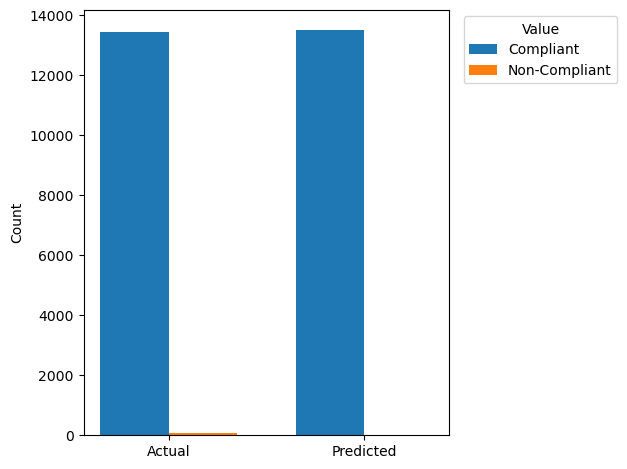

In [17]:
actual = y_test.to_numpy()
predicted = y_pred

actual_0 = np.sum(actual == 0)
actual_1 = np.sum(actual == 1)
pred_0 = np.sum(predicted == 0)
pred_1 = np.sum(predicted == 1)

groups = ["Actual", "Predicted"]
x = np.arange(len(groups))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width / 2, [actual_0, pred_0], width, label="Compliant")
ax.bar(x + width / 2, [actual_1, pred_1], width, label="Non-Compliant")

ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.set_xlabel("")
ax.set_ylabel("Count")

# move legend outside the plot frame
ax.legend(title="Value", loc="upper left", bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()


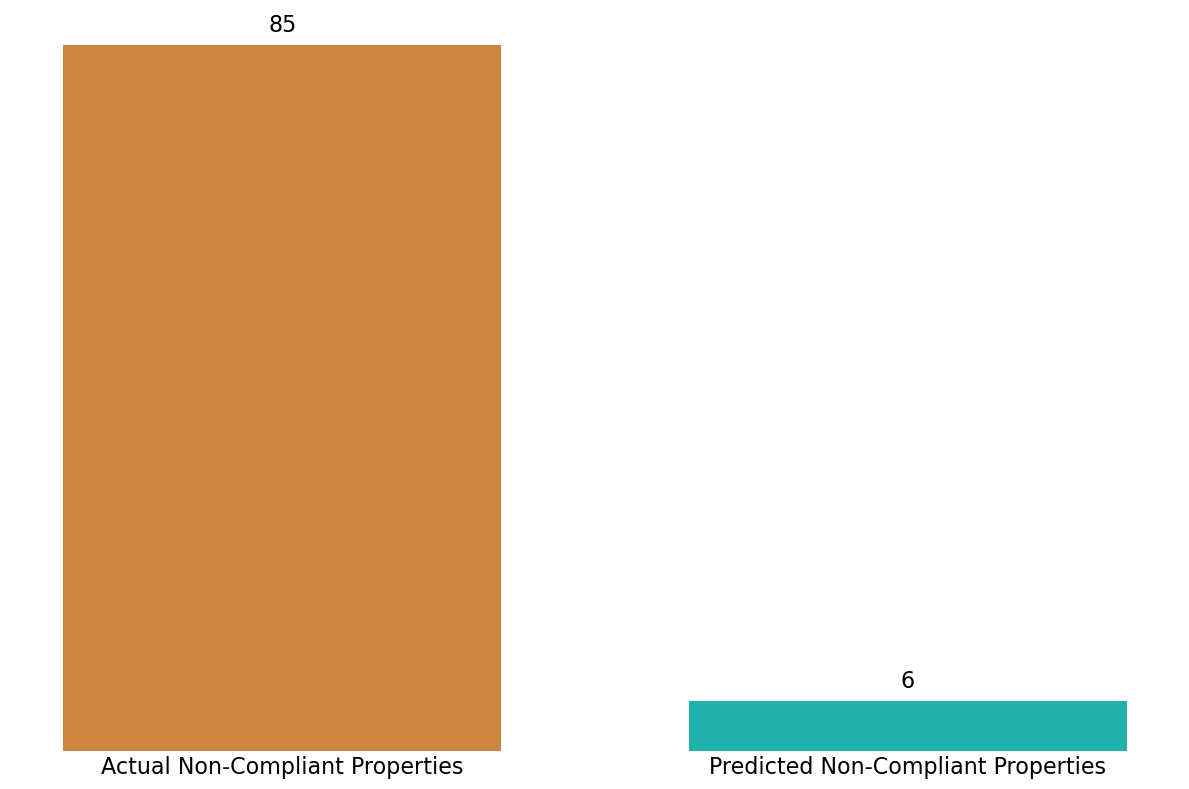

In [92]:
# import matplotlib.pyplot as plt
# import numpy as np

# actual_noncompliant = 85
# predicted_noncompliant = 6

# # Labels and positions
# labels = ["Actual Non-Compliant Properties", "Predicted Non-Compliant Properties"]
# x = np.array([0, 1])
# width = 0.7

# # Colors: orange for actual, steelblue for predicted
# colors = ["peru", "lightseagreen"]

# # Create figure & axes with transparent background
# fig, ax = plt.subplots(figsize=(12, 8), facecolor="none")
# ax.set_facecolor("none")
# fig.patch.set_alpha(0)

# # Remove frame
# for spine in ax.spines.values():
#     spine.set_visible(False)

# # Plot bars
# bars = ax.bar(x, [actual_noncompliant, predicted_noncompliant], width, color=colors)

# # Add count labels on top
# for bar in bars:
#     h = bar.get_height()
#     ax.text(
#         bar.get_x() + bar.get_width() / 2, h + 1, f"{int(h)}", ha="center", va="bottom", fontsize = 16
#     )

# # Keep x-axis labels but hide the tick markers
# ax.set_xticks(x)
# ax.set_xticklabels(labels, fontsize=16)
# ax.tick_params(axis="x", length=0)

# # Keep the y-axis title but hide tick marks and labels
# ax.set_ylabel("")
# ax.tick_params(axis="y", which="both", length=0, labelleft=False)

# # (Optionally set a title)
# ax.set_title("")

# plt.tight_layout()
# plt.show()


In [71]:
y_pred.sum()

np.int64(6)